# Tutorial 2: SPOTS (Mouse Spleen dataset)

DePass was applied to the mouse spleen SPOTS dataset (2,568 spatial spots) for cross-modal integration and data enhancement. This tutorial demonstrates: 
1. Spatial domain identification in mouse spleen tissue using DePass.
2. Validation of data enhancement through comparative analysis of biomarker log2 fold-changes (LogFC) and spatial expression patterns.
3. In addition, we calculated the Pearson Correlation Coefficient (PCC) between genes and proteins associated with the biomarkers, confirming that the enhanced data retained biological consistency.

### Preparation

In [1]:
import scanpy as sc
import torch
import random
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")

from DePass.utils import *
fix_seed(2024)  

# Environment configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

os.environ['R_HOME'] = '/home/jyx/anaconda3/envs/DePass/lib/R'
 
path = '../data/dataset_MouseSpleen'
os.mkdir(path) if not os.path.exists(path) else print(f"The directory '{path}' already exists.\n")

The directory '../data/dataset_MouseSpleen' already exists.



### Loading and Preprocessing

Load the raw count data and perform preprocessing to ensure high-quality input for model. The preprocessing methods are detailed below:
For transcriptomics, we filtered gene features to retain those detected in ≥1% of cells. Top 1,000 highly variable genes (HVGs) were selected via Seurat v3 dispersion-based method. Counts were normalized per cell (total scaling to 10^4), followed by log1p transformation and z-score standardization via scanpy package. For proteomics, protein expression matrices were normalized using centered log-ratio (CLR) transformation to address compositionality biases, followed by feature-wise z-score standardization.

In [ ]:
adata_omics1 = sc.read_h5ad('/data/jyx/data/dataset_MouseSpleen/adata_RNA.h5ad')
adata_omics2 = sc.read_h5ad('/data/jyx/data/dataset_MouseSpleen/adata_ADT.h5ad')

gene = [
'Cd3g','Cd3d','Cd3e',  
'Cd4', 
'Cd8a',
'Cd19',
'Ighd',
'Cd163'
]

preprocess_data(adata=adata_omics1,modality='rna',gene_list=gene)
preprocess_data(adata=adata_omics2,modality='protein')
adata_omics1.obsm['input_feat'] = adata_omics1.obsm['X_norm'].copy()
adata_omics2.obsm['input_feat'] = adata_omics2.obsm['X_clr'].copy()
data = {'rna': adata_omics1, 'protein': adata_omics2}


### Training the model

The DePass model is designed for multi-omics data integration at both spatial and single-cell data. After training, the output file includes the following key results:

1. **`embedding`**: Integrated embedding representation, which integrates multi-omics expression features with spatial coordinate information (for spatial data). This representation is used directly for downstream tasks (e.g., spatial domain segmentation) or visualization (e.g., UMAP). 
2. **`x1_enh`**: Enhanced feature matrix for the first omics modality.  
3. **`x2_enh`**: Enhanced feature matrix for the second omics modality.  
4. **`alpha`**: Cross-modality attention weight matrix, dynamically learned through a attention mechanism. It reflects the relative importance of each modality in clustering units (e.g., cells/spots/bins).

In [ ]:
from DePass.model import DePass
model = DePass(data, data_type='spatial',device=device)
output = model.train()

[Config]
Modalities: 2 | Data: spatial | Device: NVIDIA GeForce RTX 4090 

[Initializing]
Graph Construction : Running...
Graph Construction : Done!
Data Enhancement : Running...


Computing METIS partitioning...
Done!


Data Enhancement : Done!


[Training]
Model training starts...


100%|██████████| 200/200 [00:02<00:00, 79.32it/s] 

Model training finished!



In [ ]:
adata = adata_omics1.copy()
adata.obsm['DePass'] = model.embedding
adata.obsm['alpha'] = model.alpha 
adata.obsm['x1_enh'] = model.x1_enh
adata.obsm['x2_enh'] = model.x2_enh

### Detect spatial domain 

After the model is trained, we use the integrated representation for cluster analysis. Here we provide three optional clustering tools, including **mclust**, **leiden**, and **kmeans**. We recommend using the **mclust** algorithm for clustering and specifying the number of target clusters. In this example, we set the number of clusters to 3 and use PCA for dimensionality reduction by setting `use_pca=True`.  The clustering results are stored in the `adata` object under the key `'DePass'`. 

For visualization, we perform **spatial visualization of regions** using **matplotlib**, where colors correspond to the cluster assignments. 



In [ ]:
from DePass.utils import *
clustering(adata=adata,n_clusters=3,key='DePass',add_key='DePass',method='mclust',use_pca=True)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [7]:
adata.write(path+'/adata.h5ad')

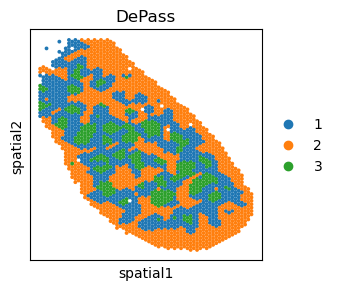

In [ ]:
from DePass.analyze_utils import plot_spatial

plot_spatial(
    adata,
    color='DePass',
    save_path=path,
    save_name='DePass',
    title="DePass",
    s=30,
    dpi=300,
    format='pdf',
    frameon =True,
    colorbar_loc='right', 
    show=True,
)

### Data Enhancement Analysis: Marker LogFC and Expression Pattern


Perform differential expression analysis using **scanpy**. Set the grouping variable to 'DePass'. Rank genes with the 'wilcoxon' method to calculate log-fold change (logFC) values. 



In [ ]:
import anndata as ad
# Create two AnnData objects to store the raw and enhanced data. 
adata1_high = adata_omics1[:,adata_omics1.var['highly_variable_all']]

adata1_R = ad.AnnData(X=adata1_high.obsm['X_norm'], obs=adata.obs[['DePass']].copy(), var=adata1_high.var.copy(), obsm={'spatial': adata1_high.obsm['spatial'].copy()})
adata1_E = ad.AnnData(X=adata.obsm['x1_enh'], obs=adata.obs[['DePass']].copy(), var=adata1_high.var.copy(), obsm={'spatial': adata1_high.obsm['spatial'].copy()})
adata2_R = ad.AnnData(X=adata_omics2.obsm['X_clr'], obs=adata.obs[['DePass']].copy(), var=adata_omics2.var.copy(), obsm={'spatial': adata_omics2.obsm['spatial'].copy()})
adata2_E = ad.AnnData(X=adata.obsm['x2_enh'], obs=adata.obs[['DePass']].copy(), var=adata_omics2.var.copy(), obsm={'spatial': adata_omics2.obsm['spatial'].copy()})


In [ ]:
# If the saved result is obtained, directly read the result for analysis
# adata1_R = sc.read(path+'/adata1_R.h5ad')
# adata1_E = sc.read(path+'/adata1_E.h5ad')
# adata2_R = sc.read(path+'/adata2_R.h5ad')
# adata2_E = sc.read(path+'/adata2_E.h5ad')

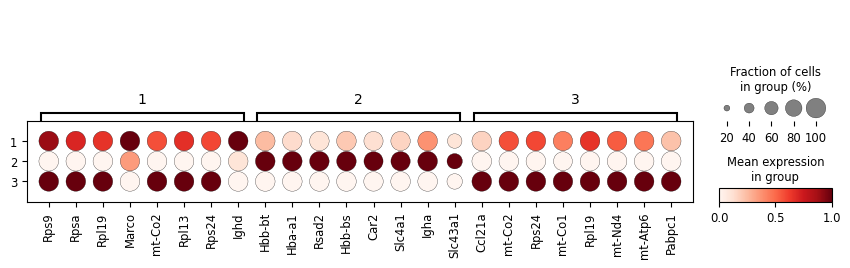

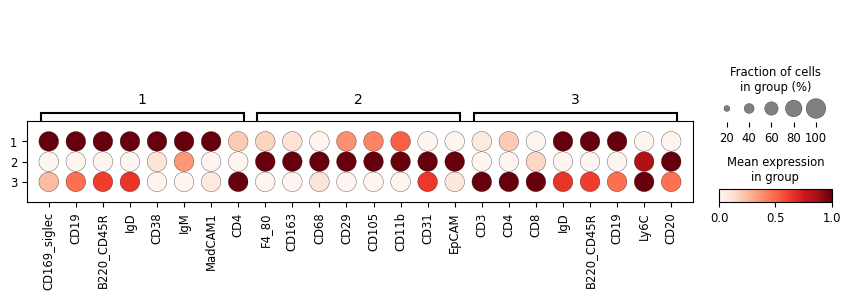

In [ ]:
from DePass.analyze_utils import rank_genes_groups
rank_genes_groups(adata=adata1_R, save_path=path, groupby='DePass', figname='rank_x1_R', method='wilcoxon', n_genes=8,show=True)
rank_genes_groups(adata=adata1_E, save_path=path, groupby='DePass', figname='rank_x1_E', method='wilcoxon', n_genes=8,show=False)
rank_genes_groups(adata=adata2_R, save_path=path, groupby='DePass', figname='rank_x2_R', method='wilcoxon', n_genes=8,show=True)
rank_genes_groups(adata=adata2_E, save_path=path, groupby='DePass', figname='rank_x2_E', method='wilcoxon', n_genes=8,show=False)

In [ ]:
# adata1_R.write(path+'/adata1_R.h5ad')
# adata1_E.write(path+'/adata1_E.h5ad')
# adata2_R.write(path+'/adata2_R.h5ad')
# adata2_E.write(path+'/adata2_E.h5ad')

In [5]:
adata = sc.read(path+'/adata.h5ad')


After obtaining logFC values from the differential analysis, use the `'visualize_marker_comparison'` function to Compare spatial expression patterns and logFC of markers.

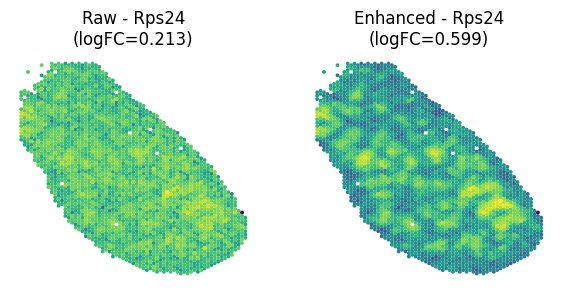

In [ ]:

from DePass.analyze_utils import *

# The user needs to specify the clustering corresponding to each marker. 
# If you are analyzing the gene Rps24 in group 3, you would set target_gene = 'Rps24' and target_group = '3'.
plot_marker_comparison_with_logFC(adata1_R, adata1_E, target_gene='Rps24', target_group='3', save_path=path, save_name='Rps24', s=30, dpi=300, show=True)

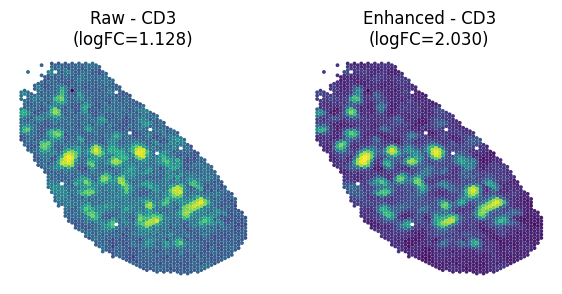

In [ ]:

from DePass.analyze_utils import *
plot_marker_comparison_with_logFC(adata2_R, adata2_E, target_gene='CD3', target_group='3', save_path=path, save_name='CD3', s=30, dpi=300, show=True)

## PCC comparison

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Define the mapping between genes and ADTs
gene_adt_mapping = {
    "CD3": ["Cd3g", "Cd3d", "Cd3e"],
    "CD4": ["Cd4"],
    "CD8": ["Cd8a"],
    "CD19": ["Cd19"],
    "IgD": ["Ighd"],
    "F4_80": ["Adgre1"],
    "CD163": ["Cd163"]
}

from DePass.analyze_utils import calculate_correlation
df_raw_pcc = calculate_correlation(adata1_R, adata2_R, gene_adt_mapping)
df_raw_pcc['type'] = 'Raw'  
df_enh_pcc = calculate_correlation(adata1_E, adata2_E, gene_adt_mapping)
df_enh_pcc['type'] = 'Enh' 
df_combined = pd.concat([df_raw_pcc, df_enh_pcc])
df_combined.to_csv(path + "/PCC.csv", sep='\t',index=False)


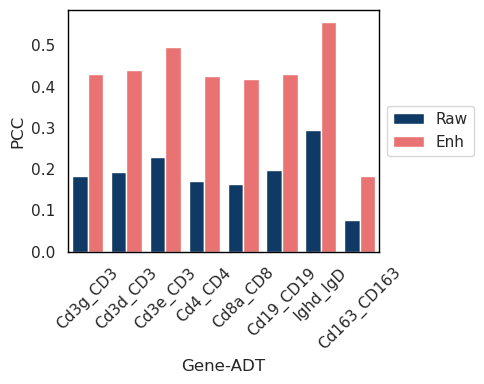

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

custom_palette = ["#003A75","#FD5F5E", "#345D82"]
sns.set(style="whitegrid")
plt.figure(figsize=(5, 3))
ax = sns.barplot(
    x="Gene_ADT",
    y="Correlation",
    hue="type",
    data=df_combined,
    palette=custom_palette
)
ax.yaxis.grid(False)
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)

plt.title("")
plt.xlabel("Gene-ADT")
plt.ylabel("PCC")
plt.xticks(rotation=45)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # 将图例放在图表外部
plt.tight_layout()
plt.savefig(path+"/PCC Comparison (Raw vs Augmented).pdf", dpi=300)
plt.show()